In [6]:
import psycopg2
from psycopg2 import sql
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

In [77]:
def get_db_connection():
    conn = psycopg2.connect(
        host="localhost",               # Nome do serviço do banco de dados no docker-compose
        database="mab_db",       # Nome do banco de dados
        user="postgres",         # Usuário do PostgreSQL
        password="password",     # Senha do PostgreSQL
        port=5433                # Porta do banco de dados
    )
    return conn

In [4]:
def get_allocations(conn):
    query = """
        SELECT allocation_date, variant_name, allocation_percentage, start_date, end_date
        FROM allocations
        ORDER BY allocation_date;
    """
    return pd.read_sql_query(query, conn)


In [61]:
def get_experiment_data(conn):
    query = """
        SELECT name, timestamp, impressions, clicks,
        (clicks::float / NULLIF(impressions, 0)) * 100 AS ctr  -- Calcular CTR, evitando divisão por zero
        
        FROM experiment_data
        ORDER BY timestamp;
    """
    return pd.read_sql_query(query,conn)

---

In [100]:
# Conectar ao banco de dados
conn = get_db_connection()

In [109]:
allocations = get_allocations(conn)
allocations

/home/aqrl-joao/active/MABExperiment-API/venv_mab/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,allocation_date,variant_name,allocation_percentage,start_date,end_date
0,2024-10-21 14:47:42.022097,A,43.19,2024-09-01,2024-09-15
1,2024-10-21 14:47:42.022097,B,56.81,2024-09-01,2024-09-15
2,2024-10-21 14:55:54.666471,A,37.99,2024-09-01,2024-09-05
3,2024-10-21 14:55:54.666471,B,62.01,2024-09-01,2024-09-05
4,2024-10-21 15:00:01.652267,A,27.59,2024-09-01,2024-09-05
5,2024-10-21 15:00:01.652267,C,28.12,2024-09-01,2024-09-05
6,2024-10-21 15:00:01.652267,B,44.29,2024-09-01,2024-09-05


In [102]:

# Buscar os dados do experimento para o intervalo
experiment_data = get_experiment_data(conn)
experiment_data



/home/aqrl-joao/active/MABExperiment-API/venv_mab/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,name,timestamp,impressions,clicks,ctr
0,B,2024-07-23 11:42:37,76,65,85.526316
1,D,2024-07-23 11:42:37,61,37,60.655738
2,C,2024-07-23 11:42:37,106,6,5.660377
3,A,2024-07-23 11:42:37,167,148,88.622754
4,C,2024-07-23 12:42:37,127,101,79.527559
...,...,...,...,...,...
19995,A,2025-02-16 17:42:37,93,78,83.870968
19996,C,2025-02-16 18:42:37,155,68,43.870968
19997,D,2025-02-16 18:42:37,176,124,70.454545
19998,B,2025-02-16 18:42:37,124,93,75.000000


----

In [108]:
experiment_data_filtered = experiment_data.copy()
experiment_data_filtered = experiment_data_filtered[experiment_data_filtered["timestamp"] > allocations.iloc[0].start_date]
experiment_data_filtered = experiment_data_filtered[experiment_data_filtered["timestamp"] < allocations.iloc[0].end_date]
experiment_data_filtered

,name,timestamp,impressions,clicks,ctr
3796,D,2024-09-01 00:42:37,151,99,65.562914
3797,B,2024-09-01 00:42:37,60,53,88.333333
3798,A,2024-09-01 00:42:37,74,63,85.135135
3799,C,2024-09-01 00:42:37,185,48,25.945946
3800,A,2024-09-01 01:42:37,136,130,95.588235
...,...,...,...,...,...
5135,C,2024-09-14 22:42:37,149,38,25.503356
5136,B,2024-09-14 23:42:37,142,43,30.281690
5137,C,2024-09-14 23:42:37,119,80,67.226891
5138,D,2024-09-14 23:42:37,164,162,98.780488


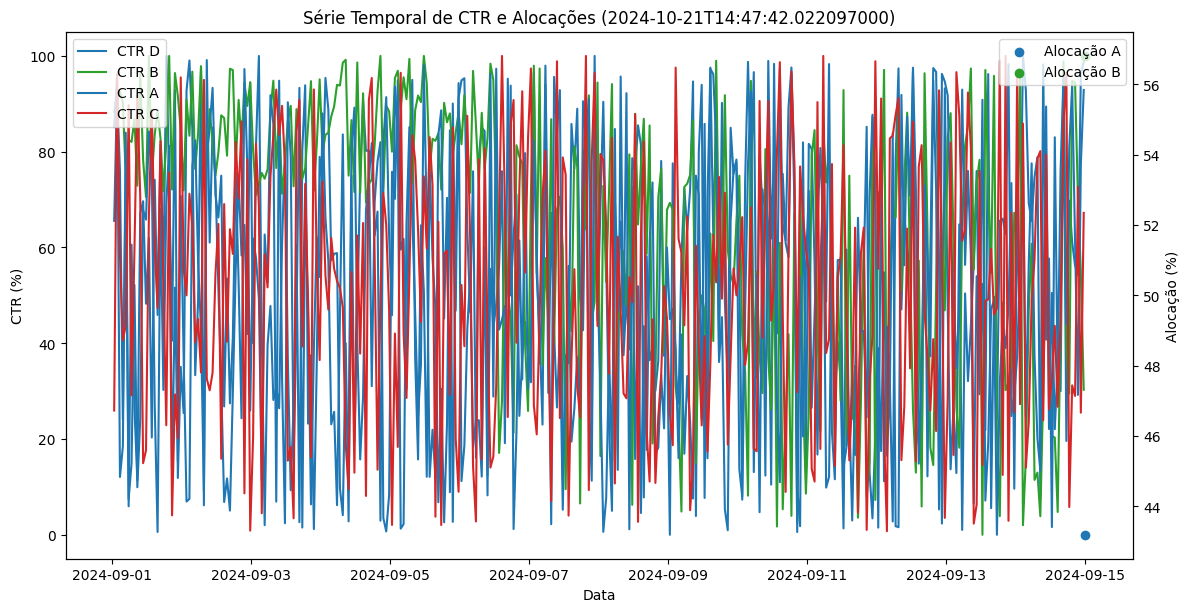

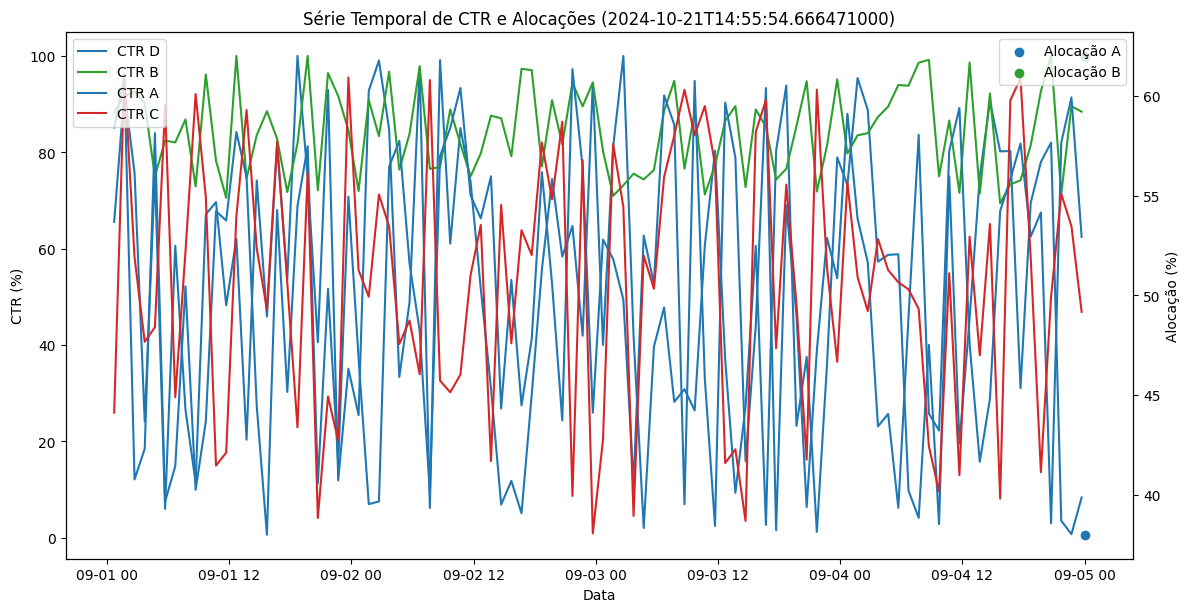

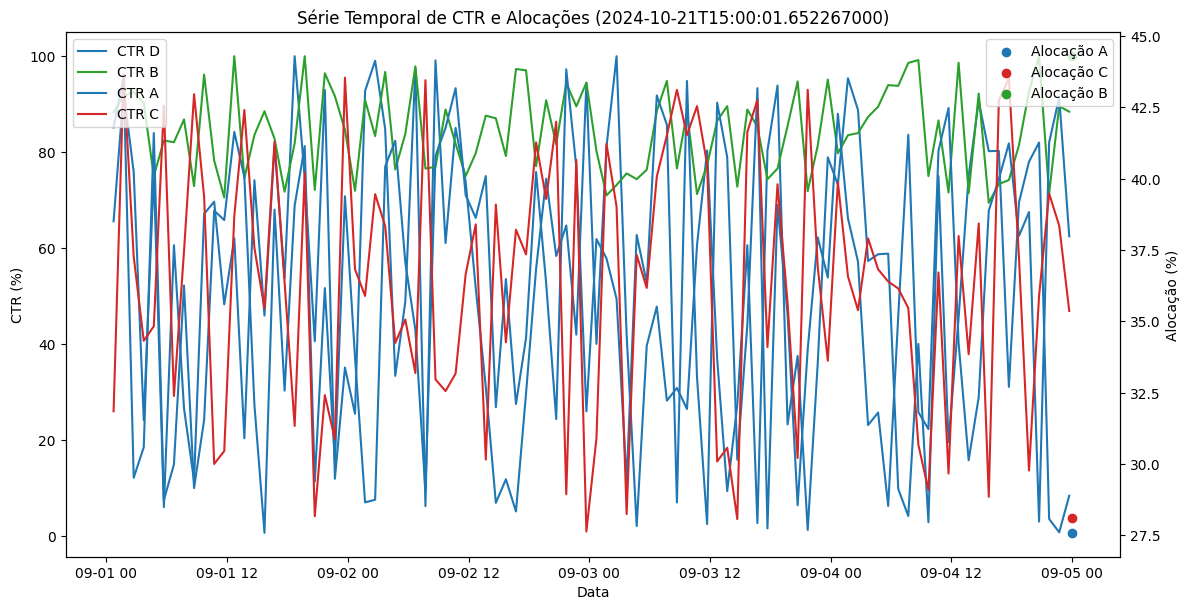

In [110]:
# Iterar sobre cada experimento baseado na allocation_date
for allocation_date in allocations['allocation_date'].unique():
    
    # Filtrar os dados de alocação para a current allocation_date
    current_allocation = allocations[allocations['allocation_date'] == allocation_date]
    
    # Filtrar os dados de experiment_data com base no start_date e end_date do experimento atual
    start_date = current_allocation.iloc[0].start_date
    end_date = current_allocation.iloc[0].end_date
    
    experiment_data_filtered = experiment_data.copy()
    experiment_data_filtered = experiment_data_filtered[
        (experiment_data_filtered["timestamp"] >= start_date) &
        (experiment_data_filtered["timestamp"] <= end_date)
    ]

    # Criar gráfico para o experimento atual
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Definir um mapeamento de cores para manter a coerência
    color_map = {
        'A': 'tab:blue',
        'B': 'tab:green',
        'C': 'tab:red'
    }

    # Plotar o CTR no eixo esquerdo
    ax1.set_xlabel('Data')
    ax1.set_ylabel('CTR (%)')

    # Plotando CTR com cores consistentes para cada variante
    for variant in experiment_data_filtered['name'].unique():
        variant_data = experiment_data_filtered[experiment_data_filtered['name'] == variant]
        
        # Plotar CTR para cada variante
        ax1.plot(variant_data['timestamp'], variant_data['ctr'], 
                 label=f'CTR {variant}', 
                 color=color_map.get(variant, 'tab:blue'))

    ax1.tick_params(axis='y')

    # Configurar o segundo eixo (direito) para alocação
    ax2 = ax1.twinx()
    ax2.set_ylabel('Alocação (%)')

    # Plotar alocação como um ponto único por variante
    for variant in current_allocation['variant_name'].unique():
        variant_allocation = current_allocation[current_allocation['variant_name'] == variant]
        
        # Colocar um ponto no gráfico para a alocação
        ax2.scatter(variant_allocation['end_date'], 
                    variant_allocation['allocation_percentage'], 
                    label=f'Alocação {variant}', 
                    color=color_map.get(variant, 'tab:red'))

    ax2.tick_params(axis='y')

    # Ajustar títulos e legendas
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.title(f'Série Temporal de CTR e Alocações ({allocation_date})')
    
    # Mostrar o gráfico
    plt.show()


----

In [ ]:
allocations_filtered = allocations.copy()
allocations_filtered = allocations_filtered[allocations_filtered["start_date"] == allocations.iloc[0].start_date]
allocations_filtered = allocations_filtered[allocations_filtered["end_date"] == allocations.iloc[0].end_date]
allocations_filtered

,allocation_date,variant_name,allocation_percentage,start_date,end_date
0,2024-10-21 14:47:42.022097,A,43.19,2024-09-01,2024-09-15
1,2024-10-21 14:47:42.022097,B,56.81,2024-09-01,2024-09-15


In [ ]:
experiment_data_filtered = experiment_data[experiment_data["name"].isin(["A", "B"])].copy()
experiment_data_filtered = experiment_data_filtered[experiment_data_filtered["timestamp"] > allocations.iloc[0].start_date]
experiment_data_filtered = experiment_data_filtered[experiment_data_filtered["timestamp"] < allocations.iloc[0].end_date]
experiment_data_filtered

,name,timestamp,impressions,clicks,ctr
3797,B,2024-09-01 00:42:37,60,53,88.333333
3798,A,2024-09-01 00:42:37,74,63,85.135135
3800,A,2024-09-01 01:42:37,136,130,95.588235
3802,B,2024-09-01 01:42:37,60,55,91.666667
3804,A,2024-09-01 02:42:37,58,7,12.068966
...,...,...,...,...,...
5131,B,2024-09-14 21:42:37,155,109,70.322581
5132,A,2024-09-14 22:42:37,84,65,77.380952
5134,B,2024-09-14 22:42:37,82,45,54.878049
5136,B,2024-09-14 23:42:37,142,43,30.281690


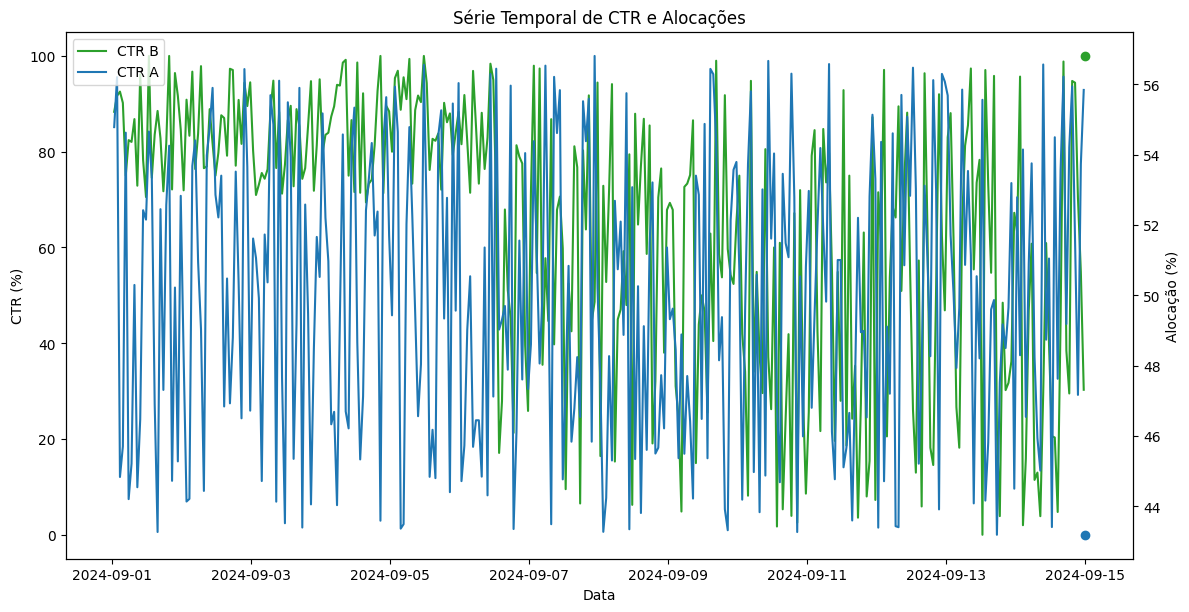

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Definir um mapeamento de cores para manter a coerência
color_map = {
    'A': 'tab:blue',
    'B': 'tab:green'
}

# Plotar o CTR no eixo esquerdo
ax1.set_xlabel('Data')
ax1.set_ylabel('CTR (%)')

# Plotando CTR com cores consistentes para cada variante
for variant in experiment_data_filtered['name'].unique():
    variant_data = experiment_data_filtered[experiment_data_filtered['name'] == variant]
    
    # Plotar CTR para cada variante
    ax1.plot(variant_data['timestamp'], variant_data['ctr'], 
             label=f'CTR {variant}', 
             color=color_map.get(variant, 'tab:blue'))

ax1.tick_params(axis='y')

# Configurar o segundo eixo (direito) para alocação
ax2 = ax1.twinx()
ax2.set_ylabel('Alocação (%)')

# Plotar alocação como um ponto único por variante
for variant in allocations_filtered['variant_name'].unique():
    variant_allocation = allocations_filtered[allocations_filtered['variant_name'] == variant]
    
    # Colocar um ponto no gráfico para a alocação
    ax2.scatter(variant_allocation['end_date'], 
                variant_allocation['allocation_percentage'], 
                label=f'Alocação {variant}', 
                color=color_map.get(variant, 'tab:red'))

ax2.tick_params(axis='y')

# Ajustar títulos e legendas
fig.tight_layout()
ax1.legend(loc='upper left')

plt.title('Série Temporal de CTR e Alocações')

# Mostrar o gráfico
plt.show()
